In [121]:
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()

from PySpice.Spice.Netlist import Circuit, SubCircuit
from PySpice.Unit import *

import numpy as np
import matplotlib.pyplot as plt


## PySpice 101

PySpice is a circuit simulator with a text interface. We are accustomed to viewing an electrical ciruit as a circuit diagram. However, representing a circuit to a computer for analysis requires a different approach. PySpice has a text interface for the purpose.

Think of the circuit diagram as a network graph. Such a graph, in Computer Science, has nodes and edges. In a circuit, junctions are nodes and components (capacitor, transistor, op amp, etc.) are edges. This is an elegant representation becuase circuit analysis examines voltage or current at a junction (with respect to ground). This manner of representation of a circuit is called *netlist* in PySpice. 

Here is an example [multisource DC circuit](https://www.allaboutcircuits.com/uploads/articles/multiple-source-DC-resistor-network-circuit-example-1.jpg): 

<img src="https://www.allaboutcircuits.com/uploads/articles/multiple-source-DC-resistor-network-circuit-example-1.jpg">

``` 
Multiple dc sources v1 1 0 dc 24 v2 3 0 dc 15 r1 1 2 10k r2 2 3 8.1k r3 2 0 4.7k .end 
```

This compact representation has the followiing components:
- The label "Multiple dc sources" 
- DC voltage source #1 with name 'v1', across nodes 0 (GND) and 1, type dc and size 24 volts
- DC voltage source #2 with name 'v2', across nodes 0 (GND) and 3, type dc and size 15 volts
- Resistor named 'r1' across nodes 1 and 2 and size 10k ohms
- Resistor named 'r2' across nodes 2 and 3 and size 8.1k ohms
- Resistor named 'r3' across nodes 0 (GND) and 2 and size 4.7k ohms.
It has only the essential information about the circuit and no fluff.

The netlist also includes provision to specify the type of simulation and content to report in output. We may want to examine the voltage or current in any of the following ways:
1. steady-state
2. transient
3. time-varying

PySpice offers these possibilities as relevant for AC or DC circuit analysis. See [examples](https://www.allaboutcircuits.com/textbook/reference/chpt-7/example-circuits-and-netlists/).

Let's try our hand at some code.

## Voltage Divider

Let's create a voltage divider. Line no. 1, create an object of class `Circuit`. Lines 3 through 5, create the netlist one edge at a time, specifing the two nodes that each edge connects. Nodes are identified with labels, 'input' and 'tap', with ground obtained as a property of the object ```circuit```. Remember that the netlist is a graph with a circuit element represented as an edge and a junction as a node. Line no. 7, print out the netlist. 

In [3]:
VoltageDivider = Circuit('Voltage Divider')

VoltageDivider.V('source', 'input', VoltageDivider.gnd, 10@u_V)
VoltageDivider.R('R1', 'input', 'tap', 9@u_kOhm)
VoltageDivider.R('R2', 'tap', VoltageDivider.gnd, 1@u_kOhm)

print(VoltageDivider)

.title Voltage Divider
Vsource input 0 10V
RR1 input tap 9kOhm
RR2 tap 0 1kOhm



Now that we have the netlist, let's analyze the circuit and see the results. Line no. 1, set up the simulator. Line no. 3, run the simulation. Observe a more complete netlist in the 1st print statement. Observe the simulation results as address of an object in the 2nd print statement.

In [4]:
simulator = VoltageDivider.simulator(temperature=25, nominal_temperature=25)
print(simulator) # More complete netlist
VoltageDividerResults = simulator.operating_point()
print(VoltageDividerResults)

2021-12-02 22:02:23,728 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Unsupported Ngspice version 35
.title Voltage Divider
Vsource input 0 10V
RR1 input tap 9kOhm
RR2 tap 0 1kOhm
.options TEMP = 25C
.options TNOM = 25C
.end



Print out the simulation results, iterating over the dictionary that has information about each node as waveform stashed using label as key.

In [5]:
for node, wave in VoltageDividerResults.nodes.items():
    print("Got {}: {}.".format(node, np.array(wave)))

Got tap: [1.].
Got input: [10.].


## MULTISOURCE DC CIRCUIT PART I

Here is an example [multisource DC circuit](https://www.allaboutcircuits.com/uploads/articles/multiple-source-DC-resistor-network-circuit-example-1.jpg): 

<img src="https://www.allaboutcircuits.com/uploads/articles/multiple-source-DC-resistor-network-circuit-example-1.jpg">


In [6]:
MultisourceDC = Circuit("MULTISOURCE DC CIRCUIT PART I")
MultisourceDC.V('V1', 1, 0, 24@u_V)
MultisourceDC.V('V2', 3, 0, 15@u_V)
MultisourceDC.R('R1', 2, 1, 10@u_kOhm)
MultisourceDC.R('R2', 3, 2, 8.1@u_kOhm)
MultisourceDC.R('R3', 2, 0, 4.7@u_kOhm)
print(MultisourceDC)

.title MULTISOURCE DC CIRCUIT PART I
VV1 1 0 24V
VV2 3 0 15V
RR1 2 1 10kOhm
RR2 3 2 8.1kOhm
RR3 2 0 4.7kOhm



In [33]:
DCsim = MultisourceDC.simulator(temperature=25, temperature_nominal=25)
print(DCsim)
results = DCsim.operating_point()
for node, wave in results.nodes.items():
    print("Got: {}: {}".format(node, np.array(wave)))

.title MULTISOURCE DC CIRCUIT PART I
VV1 1 0 24V
VV2 3 0 15V
RR1 2 1 10kOhm
RR2 3 2 8.1kOhm
RR3 2 0 4.7kOhm
.options TEMP = 25C
.options TNOM = 27C
.end

Got: 2: [9.74697417]
Got: 3: [15.]
Got: 1: [24.]


The docs cite the following example for basic usage. The steps are:
- Create a sub-circuit model by defining a class ```ParallelResistors``` derived from class ```SubCircuit```. Each instance of this class is a new custom component, usable on par with a built-in component like a resistor and can be used as a building block in circuit construction.
- Instantiate a circuit object from the class ```Circuit```, passing the constructor a text label.
- Register each sub-circuit using the ```subcircuit()``` method of 'circuit`. Then use it in the circuit. The circuit knows that this building block is a custom component by virtue of the ```X()``` method used when building the circuit. The method accepts 4 arguments as follows: The label (e.g. 'Parallel_Resistors_01') by which the component is 'known' to the circuit, the type of component, which is the name at the time of registration, the two nodes.

In [8]:
class ParallelResistors(SubCircuit):
    __nodes__ = ('01', '02')
    def __init__(self, name, R1=1@u_Ω, R2=2@u_Ω):
        SubCircuit.__init__(self, name, *self.__nodes__)
        self.R("R1", '01', '02', R1)
        self.R("R2", '01', '02', R2)

In [9]:
circuit = Circuit('Test')
circuit.subcircuit(ParallelResistors('Part_One', R2=2@u_Ω))
circuit.X('Parallel_Resistors_01', 'Part_One', 1, circuit.gnd)
circuit.subcircuit(ParallelResistors('Part_Two', R2=3@u_Ω))
circuit.X('Parallel_Resistors_02', 'Part_Two', 1, circuit.gnd)
print(circuit)

.title Test
.subckt Part_One 01 02
RR1 01 02 1Ohm
RR2 01 02 2Ohm
.ends Part_One

.subckt Part_Two 01 02
RR1 01 02 1Ohm
RR2 01 02 3Ohm
.ends Part_Two
XParallel_Resistors_01 1 0 Part_One
XParallel_Resistors_02 1 0 Part_Two



## MULTISOURCE DC CIRCUIT PART II

Here is an example [multisource DC circuit](https://www.allaboutcircuits.com/uploads/articles/multiple-source-DC-resistor-network-circuit-example-2.jpg): 

<img src="https://www.allaboutcircuits.com/uploads/articles/multiple-source-DC-resistor-network-circuit-example-2.jpg">

This time, we will simulate a DC sweep of the voltage source. 

In [10]:
MultisourceDCv2 = Circuit("MULTISOURCE DC PART II")
MultisourceDCv2.V('V1', 1, 0, 24@u_V)
MultisourceDCv2.V('V2', 3, 0, 15@u_V)
MultisourceDCv2.R('R1', 2, 1, 10@u_kOhm)
MultisourceDCv2.R('R2', 3, 2, 8.1@u_kOhm)
MultisourceDCv2.R('R3', 2, 0, 4.7@u_kOhm)


Resistor RR3

Use the ```dc()``` method of simulator and pass the sweep paramters (start, stop, step size), referring to the voltage source using its netlist symbol. The naming protocol appends a leading alphabet to the label attached to the building block during circuit construction. For example, the voltage source with the label 'V1' has become 'VV1' in the netlist. Had we labaled it 'input', it would appear as 'Vinput' in the netlist. Use ```slice()``` to present the sweep voltages as an array.

In [34]:
DC2sim = MultisourceDCv2.simulator(temperature=25, temperature_nominal=25)
print(DC2sim)
results = DC2sim.dc(VV1 = slice(24, 40, 1))
for name, data in results.nodes.items(): 
    # Each node in the circuit has a name and data from simulation results.
    print("Got: {}: {}".format(name, np.array(data)))


.title MULTISOURCE DC PART II
VV1 1 0 24V
VV2 3 0 15V
RR1 2 1 10kOhm
RR2 3 2 8.1kOhm
RR3 2 0 4.7kOhm
.options TEMP = 25C
.options TNOM = 27C
.end

Got: 2: [ 9.74697417  9.97621485 10.20545553 10.43469621 10.66393689 10.89317758
 11.12241826 11.35165894 11.58089962 11.8101403  12.03938098 12.26862167
 12.49786235 12.72710303 12.95634371 13.18558439 13.41482507]
Got: 3: [15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15. 15.]
Got: 1: [24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.]
Got: v-sweep: [24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40.]


## RC TIMECONSTANT CIRCUIT

Here is an example of an [RC time-constant circuit](https://www.allaboutcircuits.com/uploads/articles/RC-time-constant-circuit-example.jpg).

<img src="https://www.allaboutcircuits.com/uploads/articles/RC-time-constant-circuit-example.jpg">

This time, we will run a DC analysis with time-varying simulation.

In [143]:
RCCircuit = Circuit("RC TIMECONSTANT CIRCUIT")
RCCircuit.V('V1', 1, 0, 10@u_V)
RCCircuit.C('C1', 1, 2, 47@u_uF, raw_spice='ic=0')
RCCircuit.C('C2', 1, 2, 22@u_uF, raw_spice='ic=0')
RCCircuit.R('R1', 2, RCCircuit.gnd, 3.3@u_kOhm)
print(RCCircuit)

.title RC TIMECONSTANT CIRCUIT
VV1 1 0 10V
CC1 1 2 47uF ic=0
CC2 1 2 22uF ic=0
RR1 2 0 3.3kOhm



In [166]:
RCsim = RCCircuit.simulator(temperature=25, temperature_nominal=25, simulator='ngspice-shared')
print(RCsim)
results = RCsim.transient(step_time=0.05@u_s, end_time=1@u_s, use_initial_condition=True)
dV = results['1']-results['2']

.title RC TIMECONSTANT CIRCUIT
VV1 1 0 10V
CC1 1 2 47uF ic=0
CC2 1 2 22uF ic=0
RR1 2 0 3.3kOhm
.options TEMP = 25C
.options TNOM = 27C
.end



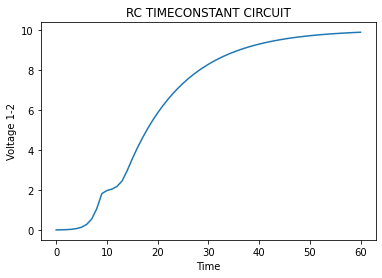

In [161]:
plt.title("RC TIMECONSTANT CIRCUIT")
plt.xlabel("Time")
plt.ylabel("Voltage 1-2")
plt.plot(dV)
plt.show()

## AC SINEWAVE VOLTAGE CIRCUIT

Here is an example of a [AC sinewave voltage circuit](https://www.allaboutcircuits.com/uploads/articles/simple-AC-sinewave-voltage-circuit.jpg).

<img src="https://www.allaboutcircuits.com/uploads/articles/simple-AC-sinewave-voltage-circuit.jpg">

We'll run a transient analysis.

In [167]:
SinewaveAC = Circuit("AC SINEWAVE VOLTAGE CIRCUIT")
source = SinewaveAC.SinusoidalVoltageSource('input', 1, SinewaveAC.gnd, amplitude=15@u_V, frequency=60@u_Hz)
SinewaveAC.R('R1', 1, SinewaveAC.gnd, 10@u_kOhm)
print(SinewaveAC)

.title AC SINEWAVE VOLTAGE CIRCUIT
Vinput 1 0 DC 0V AC 1V SIN(0V 15V 60Hz 0s 0Hz)
RR1 1 0 10kOhm



In [145]:
ACsim = SinewaveAC.simulator(temperature=25, nominal_temperature=25)
out = ACsim.transient(step_time=1@u_ms, end_time=60@u_ms)
print(out)

In [146]:
for name, data in out.nodes.items():
    print("{}: {}".format(name, np.array(data)))

1: [  0.           0.03392917   0.06785817   0.13571495   0.27141879
   0.54274871   1.08478661   2.16389228   4.28251548   8.20854068
  12.25379216  14.57803495  14.85483605  13.04531957   9.40362673
   4.44122246  -1.14493831  -6.5702959  -11.07287495 -14.02030162
 -14.99861859 -13.87042416 -10.79416987  -6.2019065   -0.7386038
   4.82843362   9.71733188  13.24145976  14.90586396  14.47678387
  12.0144825    7.86478278   2.61049768  -3.01042406  -8.20854068
 -12.25379216 -14.57803495 -14.85483605 -13.04531957  -9.40362673
  -4.44122246   1.14493831   6.5702959   11.07287495  14.02030162
  14.99861859  13.87042416  10.79416987   6.2019065    0.7386038
  -4.82843362  -9.71733188 -13.24145976 -14.90586396 -14.47678387
 -12.0144825   -7.86478278  -2.61049768   3.01042406   8.20854068
  12.25379216  14.57803495  14.85483605  13.04531957   9.40362673
   4.44122246  -1.14493831  -6.5702959   -8.81677878]


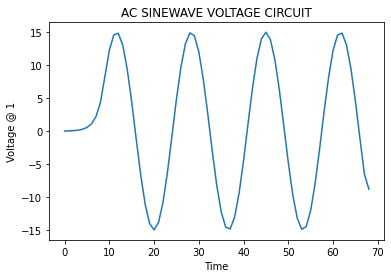

In [147]:
plt.title("AC SINEWAVE VOLTAGE CIRCUIT")
plt.xlabel("Time")
plt.ylabel("Voltage @ 1")
plt.plot(out['1'])
plt.show()